(Material adapted from Toke Faurby's and Chris Carvelli's)

# Convolutional Neural networks 101


Convolutional neural networks (or ConvNets) are a very succesfull type of neural networks, and are an integral part of reigniting the interest in neural networks.
They are able to extract structural relations in the data such as spatial in images or temporal in time series.

In this lab you will learn what *convolutional layers* are and how they work, as well as important related concepts such as *padding*, *stride*, and *pooling*.

#### External resources:
For an indept tutorial please see [stanford cs231n](http://cs231n.github.io/convolutional-networks/) or to read more see [Michael Nielsen](http://neuralnetworksanddeeplearning.com/chap6.html).


## What are convolutional networks?

ConvNets are in may respects very similar to the dense feedforward networks we saw previously:
 * The network is still organized into layers
 * Each layer is parameterized by weights and biases
 * Each layer has an element-wise non-linear transformation (activation function)
 * There are no cycles in the connections (e.g.: [Recurrent Neural Networks](https://www.ibm.com/cloud/learn/recurrent-neural-networks) have cycles. They are very useful for processing sequential data, but we are not talking about them during the course)

*So what is the difference?*
The networks we saw previously are called *dense* because each unit receives input from all the units in the previous layer.
This is not the case for ConvNets.
In ConvNets each unit is only connected to a small subset of the input units.
This is called the *receptive field* of the unit.

#### Let us look at a quick example.
Let us define a `3x3` window with the kernel weights (indicated by red in the bottom right).
We apply the window by performning elementwise multiplication, and then summing the results, as shown in this animation:

![](http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif)
[GIF courtesy of [Stanford](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution)]

After having convolved the image we perform an elementwise non-linear transformation on the *convolved features*.
In this example the input is a 2D *feature map* with depth 1.


## Strides, padding, and pooling

Two important concepts for ConvNets are *strides* and *padding*.
### Padding
describes what we do at the edges of the feature map.
If we don't use padding the feature map will get smaller every time, as we can see above. 
If we do use padding we can maintain the same resolution. 
In deep learning we generally just pad with zeros.
In the example below in the '_Padding, no strides_' GIF we maintain the size by padding with one row/column of zeros on all sides.


### Strides
describe how far the window is moved each time. Strides can be used to reduce the size of the feature map, and the number of computations that needs to be performed.

    Strides and pooling (exerpted from [here](https://github.com/vdumoulin/conv_arithmetic#convolution-animations)) are shown in the table below.
Notice how the output (green) changes shape.

| ![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif) | ![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/same_padding_no_strides.gif) | ![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_strides.gif) | ![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides.gif) |
|--------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| No padding, no strides                                                                     | Padding, no strides                                                                          | No padding, stride of 2                                                                 | Padding, stride of 2                                                                 |


### Pooling
is another method for reducing the spatial resolution. Similar to convolutional layers it works by sliding a window accross the feature map. Unlike the convolutional layers there are no learnable parameters, and the pooling layers perform the same simple operation every time. The most common types of pooling are:
 * *Max pooling* where the output of the pooling operation is the highest value in the window, and
 * *Mean pooling* which outputs the mean of the elements in the window.
 
![Max pooling image](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Max_pooling.png/471px-Max_pooling.png)
[Image courtesy of [Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)]


In [1]:
# Loading dependancies and supporting functions by running the code block below.
from __future__ import absolute_import, division, print_function 

# import time
# import sys, os

%matplotlib inline
# import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
# from IPython.display import clear_output
import tensorflow as tf
from tensorflow import keras
# from tensorflow.python.keras.callbacks import TensorBoard

from sklearn.preprocessing import OneHotEncoder

In [2]:
print("Tensorflow Version:", tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("You are not using the GPU version of TF.")

Tensorflow Version: 2.4.1
Default GPU Device:/device:GPU:0


In [3]:
# Download and load data
data_set = keras.datasets.cifar10

(x_train, y_train_),(x_test, y_test_) = data_set.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data to [0, 1] interval

y_train = OneHotEncoder(categories='auto', sparse=False).fit_transform(y_train_)
y_test = OneHotEncoder(categories='auto', sparse=False).fit_transform(y_test_)

## Print dataset statistics and visualize
print("""Information on dataset
----------------------""")
print("Training data shape:\t", x_train.shape, y_train.shape)
print("Test data shape\t\t",     x_test.shape, y_test.shape)

Information on dataset
----------------------
Training data shape:	 (50000, 32, 32, 3) (50000, 10)
Test data shape		 (10000, 32, 32, 3) (10000, 10)



Labels
[6], [9], [9], [4], [1], 
[1], [2], [7], [8], [3], 
[4], [7], [7], [2], [9], 
[9], [9], [3], [2], [6], 
[4], [3], [6], [6], [2], 

Input data


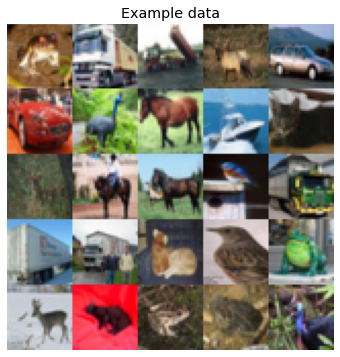

In [4]:
## Plot a few MNIST examples
img_to_show = 5
idx = 0
canvas = np.zeros((32*img_to_show, img_to_show*32, 3))
print('\nLabels')
for i in range(img_to_show):
    for j in range(img_to_show):
        canvas[i*32:(i+1)*32, j*32:(j+1)*32] = x_train[idx] #mnist_data.train.images[idx].reshape((28, 28))
        print(y_train_[idx], end=', ')
        idx += 1
    print()

print('\nInput data')
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(canvas)
plt.title('Example data')
plt.show()

# Task 1: Getting use to Convolutional Networks

In this first part you should experiment a bit, and get used to working with convolutional networks.

You task is:

1) Create a convolutional neural network, using both `Conv2D`, `MaxPooling2D` layers, with the following shapes:

    (None, 32, 32, 3) [input]
    (None, 16, 16, 16)
    (None, 7, 7, 32)
    (None, 5, 5, 64)
    (None, 2, 2, 64)
    (None, 1, 1, 128)

2) How many trainable parameters parameters does this network have?
 * `keras.model.summary` is an easy way to see the number of parameters.


3) Create a dense network with (roughly) the same number of parameters, and compare the summaries.


In [5]:
conv_model = None ## YOUR CODE HERE!

conv_model = keras.models.Sequential([
    tf.keras.layers.InputLayer((32, 32, 3)),
    
    keras.layers.Conv2D(16, (3,3), strides=(2,2), padding='same'),
    keras.layers.Activation('relu'),

    keras.layers.Conv2D(32, (3,3), strides=(2,2), padding='valid'),
    keras.layers.Activation('relu'),

    keras.layers.Conv2D(64, (3,3), strides=(1,1), padding='valid'),
    keras.layers.Activation('relu'),

    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid'),
    keras.layers.Activation('relu'),

    keras.layers.Conv2D(128, (2,2), strides=(1,1), padding='valid'),
    keras.layers.Activation('relu'),
    
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          18496     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 64)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 64)          0

In [6]:
dense_model = None ## YOUR CODE HERE!

dense_model = keras.models.Sequential([
    tf.keras.layers.InputLayer((32, 32, 3)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(19),
    keras.layers.Activation('relu'),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                58387     
_________________________________________________________________
activation_5 (Activation)    (None, 19)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                200       
Total params: 58,587
Trainable params: 58,587
Non-trainable params: 0
_________________________________________________________________


# Task 2: 

Now we want to compare the performance of dense and convolutional networks, and conduct some experiments.

Your task

1. Go back to Task 1, and update the networks such that they work (e.g. have non-linearities, and a soft-max output layer)
1. Finish the code below, and compare the performance of the convolutional and dense network.
1. For the remainder of the time try setting up hypothesies, and test them
 * How large does the dense network need to be in order to get similar performance as the convolutional?
 * When does an un-regularized convolutional network begin to overfit the data?

___
**Tip:** It might make sense to experiment with a reduced data set.
You can remove observations, all occurances of some classes, or use a smaller data set (e.g. fashion MNIST).


In [7]:
## Copied from Lab 8

try:
    experiments
except NameError:
    experiments = []

    
## Helper functions
def visualize_experiments(experiments):
    fig = plt.figure(figsize=(8,6))
    for experiment in experiments:
        exp_name, _, info = experiment
 
        ax = plt.subplot(2, 1, 1)
        ax.set_title('Validation Accuracy')
        plt.plot(info.history['val_accuracy'], label=exp_name)
        plt.legend()

        ax = plt.subplot(2, 1, 2)
        ax.set_title('Validation Loss')
        plt.plot(info.history['val_loss'], label=exp_name)
        plt.legend()

    plt.tight_layout()
    plt.show()


def visualize_info(experiment):
    name, _, info = experiment
    print('Params:')
    for key in info.params:
        print('{:20}'.format(key), info.params[key])
    
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(2, 1, 1)
    ax.set_title('Accuracy: '+ name)
    plt.plot(info.history['val_accuracy'], label='val_accuracy')
    plt.plot(info.history['accuracy'], label='train_accuracy')
    plt.legend()

    ax = plt.subplot(2, 1, 2)
    ax.set_title('Loss: ' + name)
    plt.plot(info.history['val_loss'], label='val_loss')
    plt.plot(info.history['loss'], label='loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    
def keep_best(experiments, n):
    """ Return the n best experiments."""
    if len(experiments) < n:
        return experiments
    
    exp_sorted = sorted(experiments, key=lambda x: np.max(x[2].history['val_accuracy']), reverse=True)
    return exp_sorted[:n]



# Training function
def train(model, loss, optimizer, num_epochs, exp_name=None, use_tensorboard=False):    
    exp_name = exp_name or 'log_{:.0f}'.format(time.time()*100)
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    batch_size = 256

    if use_tensorboard:
        tensorboard = TensorBoard(log_dir='logdir/'+exp_name)
        fit_info = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, callbacks=[tensorboard])
    else:
        fit_info = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)
    return exp_name, model, fit_info

In [8]:
loss_function = None
optimizer = None

## EXPERIMENT WITH THE HYPER-PARAMETERS

loss_function = tf.keras.backend.categorical_crossentropy
optimizer = keras.optimizers.Adam()

num_epochs = 25
print('\nBegin Training')
exp_name = 'conv_network'
experimentConv = train(conv_model, loss_function, optimizer, num_epochs, exp_name=exp_name)
experiments.append(experimentConv)

exp_name = 'dense_network'
experimentDense = train(dense_model, loss_function, optimizer, num_epochs, exp_name=exp_name)
experiments.append(experimentDense)



Begin Training
Epoch 1/25
176/176 [==============================] - 6s 14ms/step - loss: 2.0623 - accuracy: 0.2358 - val_loss: 1.6364 - val_accuracy: 0.3938
Epoch 2/25
176/176 [==============================] - 1s 8ms/step - loss: 1.6119 - accuracy: 0.4146 - val_loss: 1.5308 - val_accuracy: 0.4374
Epoch 3/25
176/176 [==============================] - 1s 8ms/step - loss: 1.4988 - accuracy: 0.4611 - val_loss: 1.4230 - val_accuracy: 0.4864
Epoch 4/25
176/176 [==============================] - 1s 8ms/step - loss: 1.3977 - accuracy: 0.5008 - val_loss: 1.3840 - val_accuracy: 0.5054
Epoch 5/25
176/176 [==============================] - 1s 8ms/step - loss: 1.3237 - accuracy: 0.5260 - val_loss: 1.3294 - val_accuracy: 0.5362
Epoch 6/25
176/176 [==============================] - 1s 8ms/step - loss: 1.2789 - accuracy: 0.5437 - val_loss: 1.2568 - val_accuracy: 0.5600
Epoch 7/25
176/176 [==============================] - 1s 8ms/step - loss: 1.2300 - accuracy: 0.5596 - val_loss: 1.2354 - val_accura

Params:
verbose              1
epochs               25
steps                176


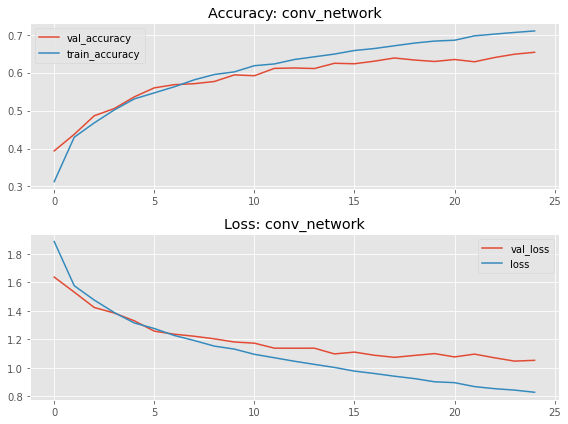

In [9]:
visualize_info(experimentConv)

Params:
verbose              1
epochs               25
steps                176


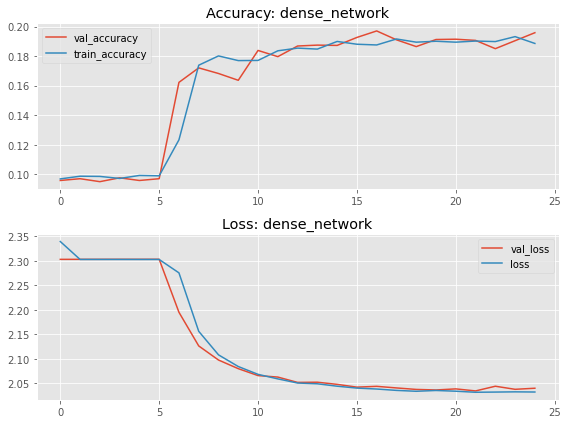

In [10]:
visualize_info(experimentDense)

# EXTRA STUFF FOR FINAL ASSIGNMENT ;)
*This section is optional for the lab, but if you end up working on a deep learning project for your final assignment, I highly suggest to take a look at the following articles. They were very useful to improve the quality of my fruit classifier.* - Francesco

## Image Data Augmentation
[By Jason Brownlee]

The performance of deep learning neural networks often improves with the amount of data available.

Data augmentation is a technique to artificially create new training data from existing training data. This is done by applying domain-specific techniques to examples from the training data that create new and different training examples.

Image data augmentation is perhaps the most well-known type of data augmentation and involves creating transformed versions of images in the training dataset that belong to the same class as the original image.

Transforms include a range of operations from the field of image manipulation, such as shifts, flips, zooms, and much more.

The intent is to expand the training dataset with new, plausible examples.

For more information:
https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

## Use Early Stopping to Halt the Training of Neural Networks At the Right Time
[By Jason Brownlee]

A problem with training neural networks is in the choice of the number of training epochs to use.

Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

In [this tutorial](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/), you will discover the Keras API for adding early stopping to overfit deep learning neural network models.

## Dropout Regularization in Deep Learning Models With Keras
[By Jason Brownlee]

A simple and powerful regularization technique for neural networks and deep learning models is dropout.

In [this post](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) you will discover the dropout regularization technique and how to apply it to your models in Python with Keras.

After reading this post you will know:

How the dropout regularization technique works.
How to use dropout on your input layers.
How to use dropout on your hidden layers.
How to tune the dropout level on your problem.

## Transfer Learning in Keras with Computer Vision Models: Start from Pre-trained models
[By Jason Brownlee]

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In [this post](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/), you will discover how to use transfer learning when developing convolutional neural networks for computer vision applications.